To convert the 3D coordinates (x, y, z) to 2D pixel coordinates on the image, we need to understand the camera's intrinsic and extrinsic parameters. These parameters define how 3D points are projected onto the 2D image plane. Here are the steps:

1. **Camera Intrinsic Parameters**: These parameters include the focal length (fx, fy), the optical center (cx, cy), and any lens distortion coefficients if necessary.

2. **Camera Extrinsic Parameters**: These parameters include the rotation matrix and the translation vector, which describe the camera's position and orientation in the world coordinate system.

3. **Projection Equation**: Use the projection equation to map 3D points to the 2D image plane.

### Step-by-Step Guide

1. **Define Camera Intrinsics**:
   - These are typically given or can be estimated through camera calibration. Assume some typical values if not available.

2. **Define Camera Extrinsics**:
   - These include the rotation matrix `R` and translation vector `T`. For simplicity, let's assume the camera is at the origin looking along the z-axis.

3. **Projection of 3D points to 2D**:
   - Apply the projection equation: 
   
   
   $\text{pixel\_coords} = \begin{bmatrix} fx & 0 & cx \\ 0 & fy & cy \\ 0 & 0 & 1 \end{bmatrix} \times [R | T] \times \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix}$

### Explanation

- **Camera Intrinsics (`K`)**: This matrix transforms 3D camera coordinates to 2D image coordinates.
- **Extrinsic Parameters (`R`, `T`)**: These matrices transform world coordinates to camera coordinates. Here, we assumed the camera is at the origin with no rotation for simplicity.
- **Projection**: The 3D points are first transformed by the extrinsic parameters and then projected to 2D using the intrinsic matrix.

### Note

- **Calibration**: In a real scenario, you need to calibrate your camera to get accurate intrinsic and extrinsic parameters.
- **Distortion**: If your camera lens introduces distortion, you need to account for that as well.
- **Coordinate System**: Ensure your 3D coordinates and the camera coordinate system are aligned.

This method should give you the pixel coordinates of the 3D points on the 2D image. Adjust the intrinsic and extrinsic parameters according to your specific setup.

In [9]:
# Load data from /Volumes/Exodus/Data/6DOF 2023/Test1

import os
import pandas as pd

# Sample data from a text file
""" 
Time (ms)	169448
Reference	-112.9437	180.4520	-208.2180	0.4736	0.4635	-0.5261	0.5330
Fenestrated	-21.9398	56.9237	-295.1500	0.0451	0.2661	-0.8368	-0.4763
Curved	-62.3648	51.9654	-243.1492	0.2314	0.3947	-0.7884	0.4112
Camera	-75.6810	35.3394	-270.7886	0.5233	-0.3824	-0.6371	-0.4171
"""


# Define the function to extract data from text files and create DataFrames for each tool
def extract_data(filepath):
    data = {"Reference": [], "Fenestrated": [], "Curved": [], "Camera": []}
    with open(filepath, "r") as file:
        lines = file.readlines()
        # Store time in milliseconds
        time = int(lines[0].split()[2])
        for line in lines[1:]:  # Skip the header
            parts = line.strip().split()
            if len(parts) == 8:
                label = parts[0]
                x, y, z = float(parts[1]), float(parts[2]), float(parts[3])
                qx, qy, qz, qw = (
                    float(parts[4]),
                    float(parts[5]),
                    float(parts[6]),
                    float(parts[7]),
                )
                data[label].append(
                    {
                        "x": x,
                        "y": y,
                        "z": z,
                        "qx": qx,
                        "qy": qy,
                        "qz": qz,
                        "qw": qw,
                    }
                )
    return data

In [27]:
# look at first 10 files
!ls "data/6DOF/Test 5" | head

0.bmp
0.mp4
0.txt
1.bmp
1.mp4
1.txt
10.bmp
10.txt
100.bmp
100.txt
ls: stdout: Undefined error: 0


In [10]:
data = extract_data("data/6DOF/Test 5/0.txt")
print(data)
# Convert the data to DataFrames and print
dfs = {tool: pd.DataFrame(data[tool]) for tool in data}
for tool in dfs:
    print(f"Tool: {tool}")
    print(dfs[tool])
    print("\n")

{'Reference': [{'x': -107.4105, 'y': 181.3588, 'z': -192.0617, 'qx': 0.5012, 'qy': 0.4877, 'qz': -0.5019, 'qw': 0.5089}], 'Fenestrated': [{'x': -46.4807, 'y': 147.7925, 'z': -293.7982, 'qx': 0.0885, 'qy': 0.1001, 'qz': -0.9751, 'qw': -0.1771}], 'Curved': [{'x': -83.8522, 'y': 128.8187, 'z': -257.996, 'qx': 0.3525, 'qy': -0.3756, 'qz': 0.8536, 'qw': -0.0777}], 'Camera': [{'x': -79.2133, 'y': 34.2041, 'z': -265.7213, 'qx': 0.605, 'qy': -0.5124, 'qz': -0.5365, 'qw': -0.289}]}
Tool: Reference
          x         y         z      qx      qy      qz      qw
0 -107.4105  181.3588 -192.0617  0.5012  0.4877 -0.5019  0.5089


Tool: Fenestrated
         x         y         z      qx      qy      qz      qw
0 -46.4807  147.7925 -293.7982  0.0885  0.1001 -0.9751 -0.1771


Tool: Curved
         x         y        z      qx      qy      qz      qw
0 -83.8522  128.8187 -257.996  0.3525 -0.3756  0.8536 -0.0777


Tool: Camera
         x        y         z     qx      qy      qz     qw
0 -79.2133  34.204

Fenestrated:
 Original: [-46.4807 147.7925]
 Pixel: [1086.56496874  137.56730981]

Curved:
 Original: [-83.8522 128.8187]
 Pixel: [1220.01085288  140.55597761]



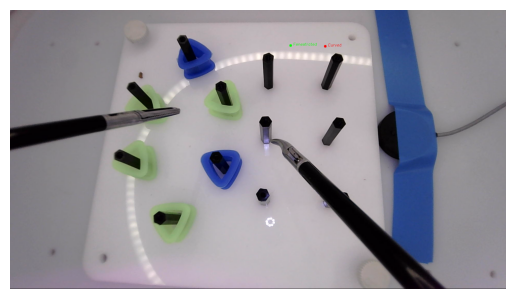

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "data/6DOF/Test 5/0.bmp"  # Replace with your actual image path
image = cv2.imread(image_path)

# Camera intrinsic parameters
fx = 800  # Focal length in x-axis
fy = 800  # Focal length in y-axis
cx = image.shape[1] / 2  # Optical center in x-axis
cy = image.shape[0] / 2  # Optical center in y-axis

# Camera extrinsic parameters are unkown, so we'll use the identity matrix
R = np.eye(3)  # Rotation matrix
T = np.zeros((3, 1))  # Translation vector

# Projection matrix
K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

# Extract 3D coordinates for the tools
points_3d = {
    "Fenestrated": np.array(
        [
            data["Fenestrated"][0]["x"],
            data["Fenestrated"][0]["y"],
            data["Fenestrated"][0]["z"],
        ]
    ),
    "Curved": np.array(
        [data["Curved"][0]["x"], data["Curved"][0]["y"], data["Curved"][0]["z"]]
    ),
}

# Convert 3D points to homogeneous coordinates
points_3d_homogeneous = {
    tool: np.hstack((coord, [1])) for tool, coord in points_3d.items()
}

# Apply extrinsic parameters (transform to camera coordinate system)
extrinsic_matrix = np.hstack((R, T))

# Project 3D points to 2D
points_2d_homogeneous = {
    tool: K @ (extrinsic_matrix @ coord.reshape(-1, 1))
    for tool, coord in points_3d_homogeneous.items()
}
points_2d = {
    tool: coord[:2] / coord[2] for tool, coord in points_2d_homogeneous.items()
}

# Convert to pixel coordinates
pixel_coords = {tool: coord.flatten() for tool, coord in points_2d.items()}

# Draw the tool positions on the image
for tool, coord in pixel_coords.items():
    color = (0, 255, 0) if tool == "Fenestrated" else (0, 0, 255)
    cv2.circle(image, (int(coord[0]), int(coord[1])), 5, color, -1)
    cv2.putText(
        image,
        tool,
        (int(coord[0]) + 10, int(coord[1])),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        color,
        1,
    )
    print(f"{tool}:\n Original: {points_3d[tool][:2]}\n Pixel: {coord}\n")

# Display the image with the overlaid tool positions
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

Fenestrated Tool Image Coordinates: [ 1.64775766 -1.75092877]
Curved Tool Image Coordinates: [ 1.43304878 -2.42283089]


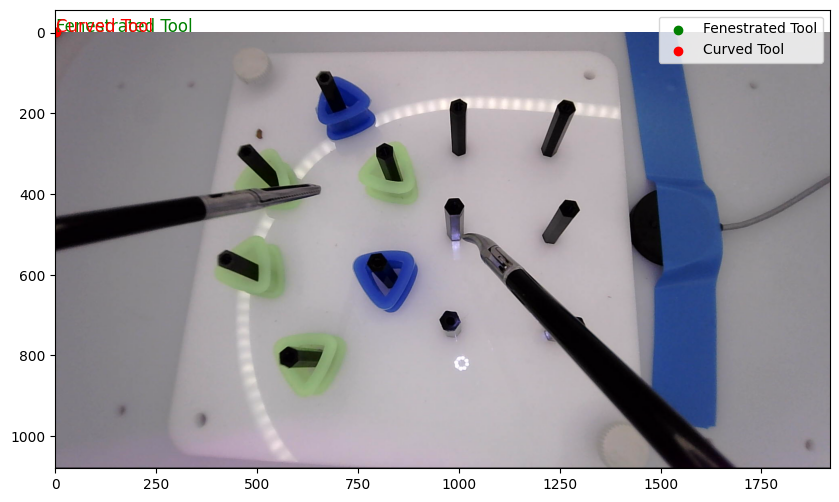

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R
from PIL import Image


# Function to apply quaternion rotation
def rotate_vector(quat, vec):
    r = R.from_quat(quat)
    return r.apply(vec)


# Function to project 3D points to 2D image coordinates
def project_to_image(point, focal_length=1.0):
    return point[:2] / point[2] * focal_length


reference = data["Reference"][0]
fenestrated = data["Fenestrated"][0]
curved = data["Curved"][0]
camera = data["Camera"][0]

# Reference tool position and orientation
ref_position = np.array([reference["x"], reference["y"], reference["z"]])
ref_orientation = [reference["qx"], reference["qy"], reference["qz"], reference["qw"]]

# Camera position and orientation
cam_position = np.array([camera["x"], camera["y"], camera["z"]])
cam_orientation = [camera["qx"], camera["qy"], camera["qz"], camera["qw"]]

# Transform fenestrated tool
fenestrated_position = np.array([fenestrated["x"], fenestrated["y"], fenestrated["z"]])
translated_fenestrated = fenestrated_position - ref_position
rotated_fenestrated = rotate_vector(ref_orientation, translated_fenestrated)

# Transform curved tool
curved_position = np.array([curved["x"], curved["y"], curved["z"]])
translated_curved = curved_position - ref_position
rotated_curved = rotate_vector(ref_orientation, translated_curved)

# Transform to camera coordinate system
translated_fenestrated_cam = rotated_fenestrated - cam_position
translated_curved_cam = rotated_curved - cam_position

rotated_fenestrated_cam = rotate_vector(cam_orientation, translated_fenestrated_cam)
rotated_curved_cam = rotate_vector(cam_orientation, translated_curved_cam)

# Project to 2D image coordinates
fenestrated_image_coords = project_to_image(rotated_fenestrated_cam)
curved_image_coords = project_to_image(rotated_curved_cam)

print(f"Fenestrated Tool Image Coordinates: {fenestrated_image_coords}")
print(f"Curved Tool Image Coordinates: {curved_image_coords}")

# fenestrated_image_coords += np.array([cx, cy])
# curved_image_coords += np.array([cx, cy])

# Load image
img_path = "data/6DOF/Test 5/0.bmp"
img = Image.open(img_path)

# Plot image and points
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.scatter(
    fenestrated_image_coords[0],
    fenestrated_image_coords[1],
    color="green",
    label="Fenestrated Tool",
)
plt.scatter(
    curved_image_coords[0], curved_image_coords[1], color="red", label="Curved Tool"
)

# Annotate points
plt.text(
    fenestrated_image_coords[0],
    fenestrated_image_coords[1],
    "Fenestrated Tool",
    color="green",
    fontsize=12,
)
plt.text(
    curved_image_coords[0],
    curved_image_coords[1],
    "Curved Tool",
    color="red",
    fontsize=12,
)

plt.legend()
plt.show()

In [26]:
from hmac import new
import os 
import cv2
    
for file in os.listdir("data/6DOF/Test 5"):
    # check file not already converted
    new_file = file.replace(".bmp", ".png")
    new_file_path = os.path.join("data/6DOF/input", new_file)
    if file.endswith(".bmp") and not os.path.exists(new_file_path) and not file.startswith("."):
        img = cv2.imread(os.path.join("data/6DOF/Test 5", file))
        cv2.imwrite(new_file_path, img)
        print(f"Converted {file} to PNG")